## Import dependencies and data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# Load data
gym_data = pd.read_csv('../Data_Source/gym_members.csv')

## Exploratory Data Analysis

A heatmap will be used to identify the relevant features to be used in the model

In [ ]:
# Overview of the dataset
print(gym_data.info())
print(gym_data.describe())
print(gym_data['Experience_Level'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

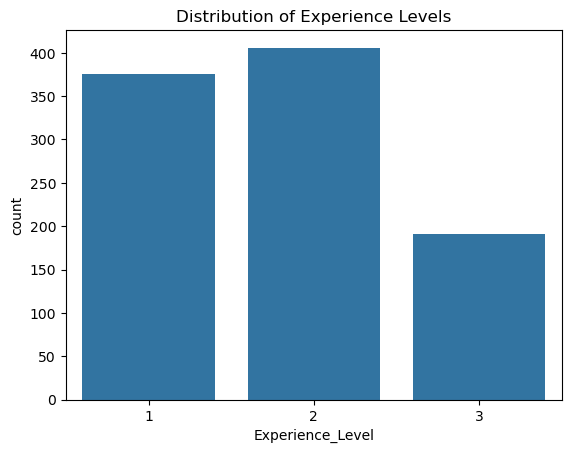

In [4]:
# Visualize class distribution
sns.countplot(x='Experience_Level', data=gym_data)
plt.title('Distribution of Experience Levels')
plt.show()

In [5]:
# Correlation heatmap - Select only numeric columns
numeric_columns = gym_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_columns.corr()

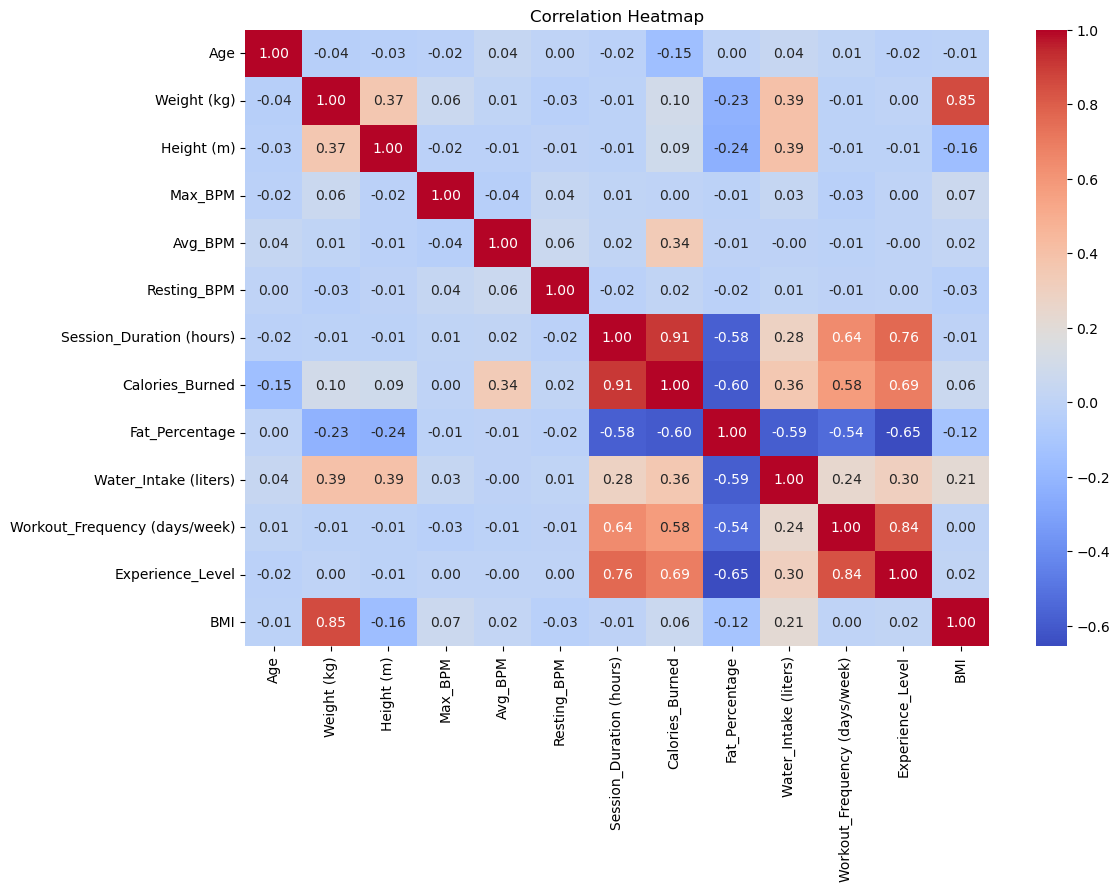

In [6]:
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Data Preprocessing

In [12]:
# Drop the target variable
X = gym_data.drop("Experience_Level", axis=1)
y = gym_data["Experience_Level"]

In [13]:
# Convert categorical columns (e.g., Gender, Workout_Type) to numeric using one-hot encoding
categorical_columns = ['Gender', 'Workout_Type']  # Add any other categorical columns here
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Train the Random Forest Model

This model is suitable for this type of application to handle categorical and numerical data and since we are using a considerable number of features, this model handles very well the high dimensionality of this project.

In [ ]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [17]:
# Predictions
y_pred = clf.predict(X_test_scaled)

In [18]:
# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.94      0.81      0.87        78
           2       0.83      0.95      0.88        75
           3       1.00      1.00      1.00        42

    accuracy                           0.90       195
   macro avg       0.92      0.92      0.92       195
weighted avg       0.91      0.90      0.90       195

Confusion Matrix:
 [[63 15  0]
 [ 4 71  0]
 [ 0  0 42]]


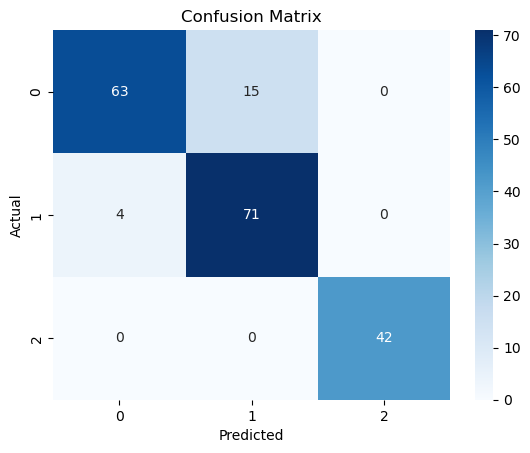

In [19]:
# Visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Hyperparameter Tuning

Model is already showing good accuracy. Still using hyperparameter tuning to improve the model for deployment

In [20]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

In [21]:
# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [22]:
# Best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}


In [23]:
# Evaluate optimized model
best_model = grid_search.best_estimator_
y_pred_optimized = best_model.predict(X_test_scaled)
print("Optimized Classification Report:\n", classification_report(y_test, y_pred_optimized))

Optimized Classification Report:
               precision    recall  f1-score   support

           1       0.97      0.81      0.88        78
           2       0.83      0.97      0.90        75
           3       1.00      1.00      1.00        42

    accuracy                           0.91       195
   macro avg       0.93      0.93      0.93       195
weighted avg       0.92      0.91      0.91       195



## Feature Importance

In this version, many features are going to be used but this feature importance process will help to identify which features have the highest influence in the outcome we want to get which is the experience level of the user to recommend the best plan.

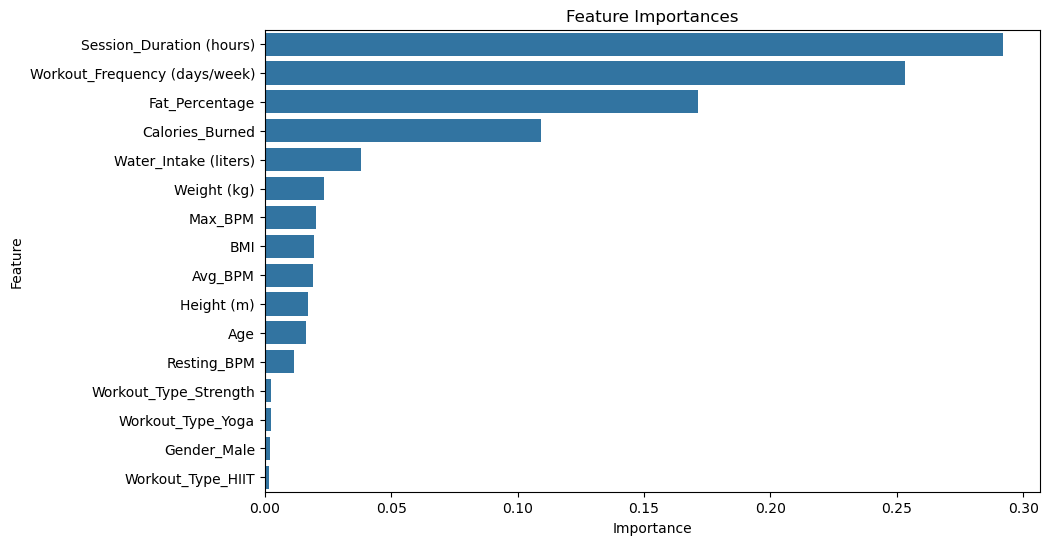

In [24]:
# Feature importance plot
importances = best_model.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()

## Saving the model for deployment

In [25]:
# Save the best model
joblib.dump(best_model, "experience_level_model.pkl")
joblib.dump(scaler, "scaler.pkl")  # Save the scaler for future use

['scaler.pkl']